# Training a classification model for wine production quality

### Objective:

In this lab, you will use the Keras Sequential API to create a classification model. You will learn how to use the tf.data API for creating input pipelines and use feature columns to prepare the data to be consumed by a neural network. 

### Not in scope:
It is out of the scope of this lab to make predictions on the model or to deploy it to Cloud AI Platform.


### Learning objectives:
- Apply techniques to clean and inspect data.
- Split dataset into training, validation and test datasets.
- Use the tf.data.Dataset to create an input pipeline.
- Define, compile and train a model using the Keras Sequential API.

In a *classification* problem, we aim to select the output from a limited set of discrete values, like a category or a class. Contrast this with a *regression* problem, where we aim to predict a value from a continuos range of values.

This notebook uses the [Wine Production Quality](https://archive.ics.uci.edu/ml/datasets/wine+quality) Dataset and builds a model to predict the production quality of wine given a set of attributes such as its citric acidity, density, and others. 

To do this, we'll provide the model with examples of different wines produced, that received a rating from an evaluator. The ratings are provided by the numbers 0 - 10 (0 being of very poor quality and 10 being of great quality).  We will then try and use this model to predict the rate a new wine will receive by infering towards the trained model.

Since we are learning how to use the Tensorflow 2.x API, this example uses the `tf.keras` API. Please see [this guide](https://www.tensorflow.org/guide/keras) for details.

In [1]:
# Use some functions from tensorflow_docs
!pip install git+https://github.com/tensorflow/docs

# Ensure the right version of Tensorflow is installed.
!pip freeze | grep tensorflow==2.1 || pip install tensorflow==2.1

  Cloning https://github.com/tensorflow/docs to /tmp/pip-req-build-4hf0ooxn
  Running command git clone -q https://github.com/tensorflow/docs /tmp/pip-req-build-4hf0ooxn
  Created wheel for tensorflow-docs: filename=tensorflow_docs-0.0.076b63aab4868862a8888bbeed07881fb0e5cf1d7_-py3-none-any.whl size=100466 sha256=dd2395b9c004d73c93899751e9fdf35ca968e81fdbc47319c0809d0519d33dd6
  Stored in directory: /tmp/pip-ephem-wheel-cache-0pvx7kq0/wheels/cc/c4/d8/5341e93b6376c5c929c49469fce21155eb69cef1a4da4ce32c
Successfully built tensorflow-docs
  Attempting uninstall: tensorflow-docs
    Found existing installation: tensorflow-docs 0.0.0
    Uninstalling tensorflow-docs-0.0.0:
      Successfully uninstalled tensorflow-docs-0.0.0


In [2]:
from __future__ import absolute_import, division, print_function, unicode_literals

import pathlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

print(tf.__version__)

2.1.0


In [3]:
import tensorflow_docs as tfdocs
import tensorflow_docs.plots
import tensorflow_docs.modeling
from sklearn.model_selection import train_test_split

## The Wine Quality Dataset

The dataset is available in the [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/).



### Get the data
There is a copy of the White Wine dataset available on Google Cloud Storage (GCS). 
The cell below shows the location of the CSV file.

In [4]:
dataset_path = "gs://cloud-training-demos/wine_quality/winequality-white.csv"

To visualize and manipulate the data, we will use [pandas](https://pandas.pydata.org/docs/).

First step is to import the data. We should list the columns that will be used to train our model. These column names will define what data will compose the [dataframe](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.html) object in pandas.

In [5]:
column_names = ['fixed_acidity','volatile_acidity','citric_acid','residual_sugar',
                'chlorides','free_sulfur_dioxide','total_sulfur_dioxide','density',
                'pH','sulphates','alcohol','quality']

In [6]:
raw_dataframe = pd.read_csv(dataset_path, names=column_names, header = 0, 
                      na_values = " ", comment='\t',
                      sep=";", skipinitialspace=True)

raw_dataframe = raw_dataframe.astype(float)
raw_dataframe['quality'] = raw_dataframe['quality'].astype(int)
dataframe= raw_dataframe.copy()


### Clean the data

Datasets sometimes can have null values. Running the next cell counts how many null values exist on each one of the columns. 

**Note: There are many other steps to make sure the data is clean, but this is out of the scope of this exercise.

In [7]:
dataframe.isna().sum()

fixed_acidity           0
volatile_acidity        0
citric_acid             0
residual_sugar          0
chlorides               0
free_sulfur_dioxide     0
total_sulfur_dioxide    0
density                 0
pH                      0
sulphates               0
alcohol                 0
quality                 0
dtype: int64

We can see that, on this dataset, there are no null values.
If there were any, we could run `dataframe = dataframe.dropna()` to drop them and make this tutorial simpler.

### Inspect the data

Let's take a look at the dataframe content. The tail() method, when ran on a dataframe, shows the last n roles (n is 5 by default).

In [8]:
dataframe.tail()

,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,pH,sulphates,alcohol,quality
4893,6.2,0.21,0.29,1.6,0.039,24.0,92.0,0.99114,3.27,0.50,11.2,6
4894,6.6,0.32,0.36,8.0,0.047,57.0,168.0,0.99490,3.15,0.46,9.6,5
4895,6.5,0.24,0.19,1.2,0.041,30.0,111.0,0.99254,2.99,0.46,9.4,6
4896,5.5,0.29,0.30,1.1,0.022,20.0,110.0,0.98869,3.34,0.38,12.8,7
4897,6.0,0.21,0.38,0.8,0.020,22.0,98.0,0.98941,3.26,0.32,11.8,6


In [9]:
data_stats = dataframe.describe()
data_stats = data_stats.transpose()
data_stats

,count,mean,std,min,25%,50%,75%,max
fixed_acidity,4898.0,6.854788,0.843868,3.80000,6.300000,6.80000,7.3000,14.20000
volatile_acidity,4898.0,0.278241,0.100795,0.08000,0.210000,0.26000,0.3200,1.10000
citric_acid,4898.0,0.334192,0.121020,0.00000,0.270000,0.32000,0.3900,1.66000
residual_sugar,4898.0,6.391415,5.072058,0.60000,1.700000,5.20000,9.9000,65.80000
chlorides,4898.0,0.045772,0.021848,0.00900,0.036000,0.04300,0.0500,0.34600
free_sulfur_dioxide,4898.0,35.308085,17.007137,2.00000,23.000000,34.00000,46.0000,289.00000
total_sulfur_dioxide,4898.0,138.360657,42.498065,9.00000,108.000000,134.00000,167.0000,440.00000
density,4898.0,0.994027,0.002991,0.98711,0.991723,0.99374,0.9961,1.03898
pH,4898.0,3.188267,0.151001,2.72000,3.090000,3.18000,3.2800,3.82000
sulphates,4898.0,0.489847,0.114126,0.22000,0.410000,0.47000,0.5500,1.08000


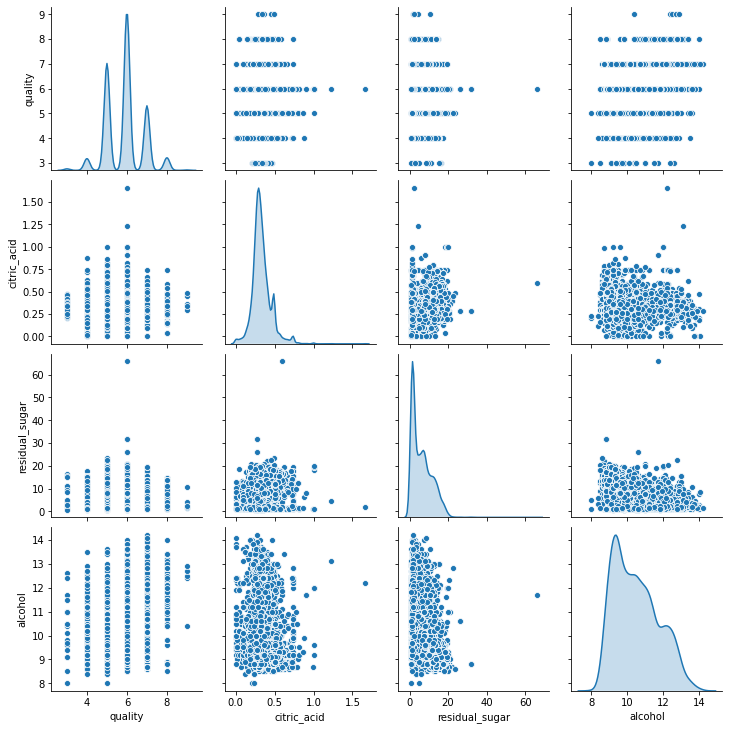

In [10]:
import seaborn as sns

sns.pairplot(dataframe[["quality", "citric_acid", "residual_sugar", "alcohol"]], diag_kind="kde")

### --- Some considerations ---

Did you notice anything when looking at the stats table?

One useful piece of information we can get from those are, for example, min and max values. This allows us to understand ranges in which these features fall in.

Based on the description of the dataset and the task we are trying to achieve, do you see any issues with the examples of have available to train on?


### Split the data into train, validation and test

Now split the dataset into a training, validation, and test sets.

We will use the test set in the final evaluation of our model.

There are more sophisticated ways to make sure that you splitting methods are repeatable. Ideally, the sets would always be the same after splitting to avoid randomic results, which makes experimentation difficult.

In [ ]:
train, test = train_test_split(dataframe, test_size=0.2)
train, val = train_test_split(train, test_size=0.2)
print(len(train), 'train examples')
print(len(val), 'validation examples')
print(len(test), 'test examples')

### Use the tf.data.Dataset

The tf.data.Dataset allows for writing descriptive and efficient input pipelines. Dataset usage follows a common pattern:

- Create a source dataset from your input data.
- Apply dataset transformations to preprocess the data.
- Iterate over the dataset and process the elements.

Iteration happens in a streaming fashion, so the full dataset does not need to fit into memory.

The `df_to_dataset` method below creates a dataset object from a pandas dataframe.

In [ ]:
def df_to_dataset(dataframe, epochs=10, shuffle=True, batch_size=8):
  dataframe = dataframe.copy()
  labels = dataframe.pop('quality') #extracting the column which contains the training label
  ds = tf.data.Dataset.from_tensor_slices((dict(dataframe), labels))
  if shuffle:
    ds = ds.shuffle(buffer_size=len(dataframe))
  ds = ds.repeat(epochs).batch(batch_size)
  return ds

Next step is to create batches from train, validation and test datasets that we split earlier. Let's use a batch size of 5 for demonstration purposes.

In [ ]:
train_ds = df_to_dataset(train)
val_ds = df_to_dataset(val, shuffle=False)
test_ds = df_to_dataset(test, shuffle=False)


Let's look at one batch of the data. The example below prints the content of a batch (column names, elements from the `citric_acid` column and elements from the `quality` label.

In [ ]:
for feature_batch, label_batch in train_ds.take(1):
  print('Every feature:', list(feature_batch.keys()))
  print('A batch of citric acid:', feature_batch['citric_acid'])
  print('A batch of quality:', label_batch )

### Create feature columns

TensorFlow provides many types of feature columns. In this exercise, all the feature columns are already of type `numeric`. If there were any text or categorical values, transformations would need to take place to make the input all numeric.

Feature columns are the object type used to create `feature layers`, which we will feed to the Keras model.

**Lab Task # 1**: Create a feature column. Hint: use the `feature_column.numeric_column` method.

In [ ]:
from tensorflow import feature_column

feature_columns = []

# Create input layer of feature columns
# TODO 1


In [ ]:
# Create a feature layer from the feature columns

feature_layer = tf.keras.layers.DenseFeatures(feature_columns)

### Define, compile and train the Keras model

We will be using the [Keras Sequential API](https://keras.io/api/models/sequential/) to creare the logistic regression model for the classification of the wine quality.

The model will be composed of the input layer (feature_layer created above), a single dense layer with two neural nodes, and the output layer, which will allow the model to predict the rating (1 - 10) of each instance being inferred.

When compiling the model, we define a loss function, an optimizer and which metrics to use to evaluate the model. `CategoricalCrossentropy` is a type of loss used in classification tasks. Losses are a mathematical way of measuring how wrong the model predictions are.

Optimizers tie together the loss function and model parameters by updating the model in response to the output of the loss function. In simpler terms, optimizers shape and mold your model into its most accurate possible form by playing with the weights. The loss function is the guide to the terrain, telling the optimizer when it’s moving in the right or wrong direction. We will use `Stochastic Gradient Descent` as our optimizer for this exercise.

There are many types of optimizers one can chose from. Ideally, when creating an ML model, try and identify an optimizer that has been empirically adopted on similar tasks.

**Lab Task # 2**: Create a deep neural network using Keras's Sequential API. In the cell below, use the tf.keras.layers library to create all the layers for your deep neural network.

In [ ]:
# Build a keras DNN model using Sequential API
# TODO 2
model = # TODO: Your code goes here.

In [ ]:
model.compile(optimizer='sgd',
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

model.fit(train_ds,
          validation_data=val_ds)

In [ ]:
model.summary()

## Conclusion

This notebook introduced a few concepts to handle a classification problem with Keras Sequential API.

* We looked at some techniques to clean and inspect data.
* We split the dataset into training, validation and test datasets.
* We used the tf.data.Dataset to create an input pipeline.
* We went over some basics on loss and optimizers.
* We covered the steps to define, compile and train a model using the Keras Sequential API.